In [1]:
import sys
sys.path.insert(0, '..')

In [2]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np

In [3]:
from iactrace import (
    Telescope, MCIntegrator, hexshow, squareshow
)

# Creating a response matrix (effective aperture).
## Introduction
For some programs or tasks a pre-computed response matrix including the effective aperture depending on stellar position is advantageous. Nyx (differentiable rendering of night sky background) makes heavy use of them.
We implemented a convenience function to render these directly.

## Preparation
We first import the HESS_I telescope as an example:

In [4]:
telescope = Telescope.from_yaml('../configs/HESS/CT3.yaml', MCIntegrator(64), key = jax.random.key(42))

Then we apply mirror roughness:

In [1]:
telescope = telescope.apply_roughness(28)

NameError: name 'telescope' is not defined

## Generating response matrix for all pixels for one telescope configuration
We can then create a grid of stellar sources (with unit flux) within our FoV:

In [6]:
fov_deg = 5.5
fov_rad = fov_deg * jnp.pi / 180

n_side = 512

x1d = jnp.linspace(-fov_rad / 2, fov_rad / 2, n_side)
y1d = jnp.linspace(-fov_rad / 2, fov_rad / 2, n_side)

X, Y = jnp.meshgrid(x1d, y1d, indexing="xy")

x = X.ravel()
y = Y.ravel()
z = -jnp.ones(n_side**2)

test_sources = jnp.stack([x, y, z], axis=1)
test_sources = test_sources / jnp.linalg.norm(test_sources, axis=1, keepdims=True)

Then we import and use the convenience function to render a response matrix for the hexagonal sensor:

In [23]:
%%time
from iactrace.core import render_response_matrix
r_m = render_response_matrix(telescope, test_sources, jnp.ones(test_sources.shape[0]), 'parallel', sensor_idx=0).block_until_ready()

CPU times: user 5.43 ms, sys: 8.58 ms, total: 14 ms
Wall time: 24.9 s


We can visualize the response matrix from the view of the stars (getting the total effective aperture for each star position):

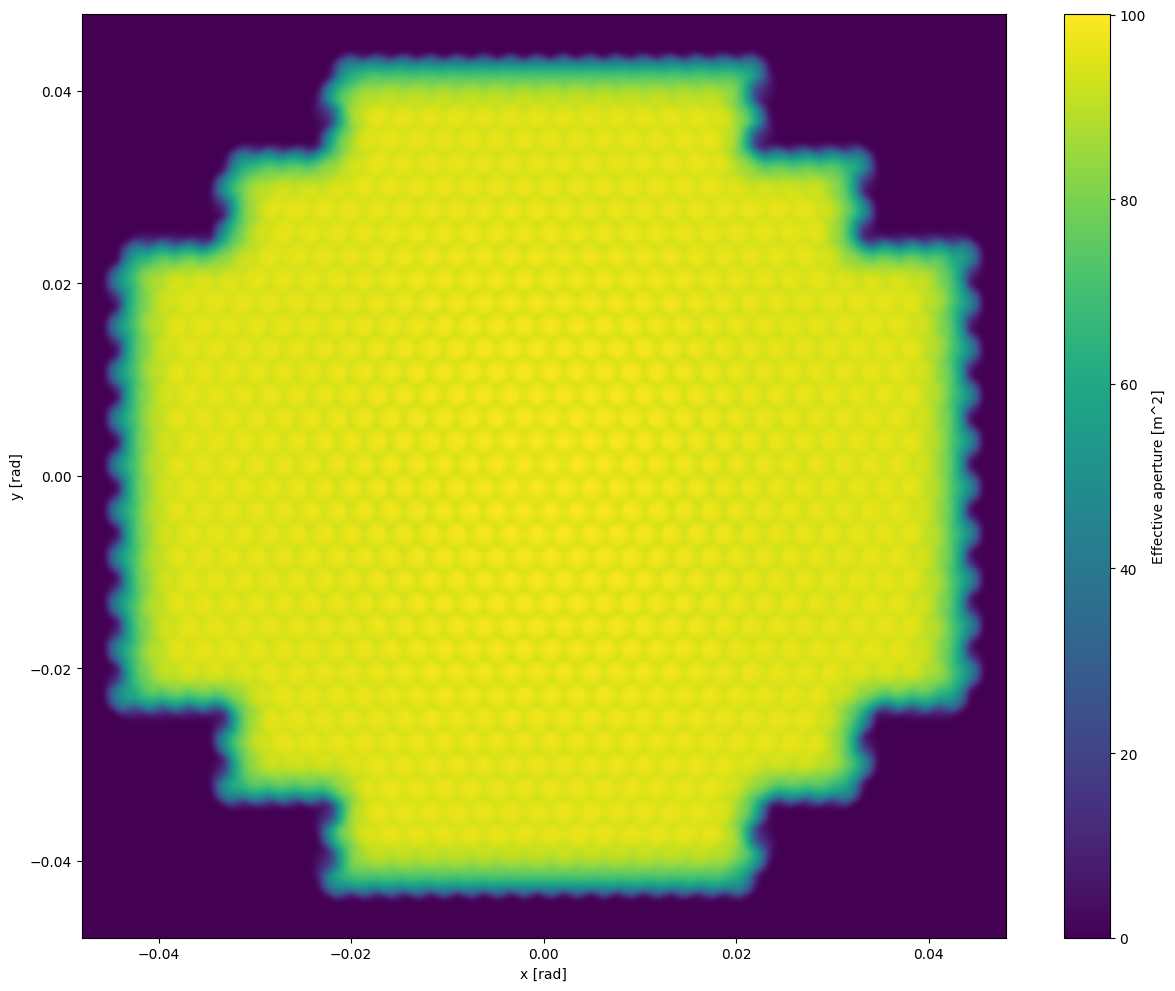

In [24]:
fig, ax = plt.subplots(figsize=(15, 12))

weights = r_m.sum(axis=-1).reshape(n_side, n_side)

im = ax.imshow(
    weights,
    origin="lower",
    extent=[x1d[0], x1d[-1], y1d[0], y1d[-1]],
)

cbar = fig.colorbar(im, ax=ax)
cbar.set_label("Effective aperture [m^2]")  # colorbar label

ax.set_xlabel("x [rad]")
ax.set_ylabel("y [rad]")

plt.show()

Alternatively we can look at the per-pixel effective aperture:

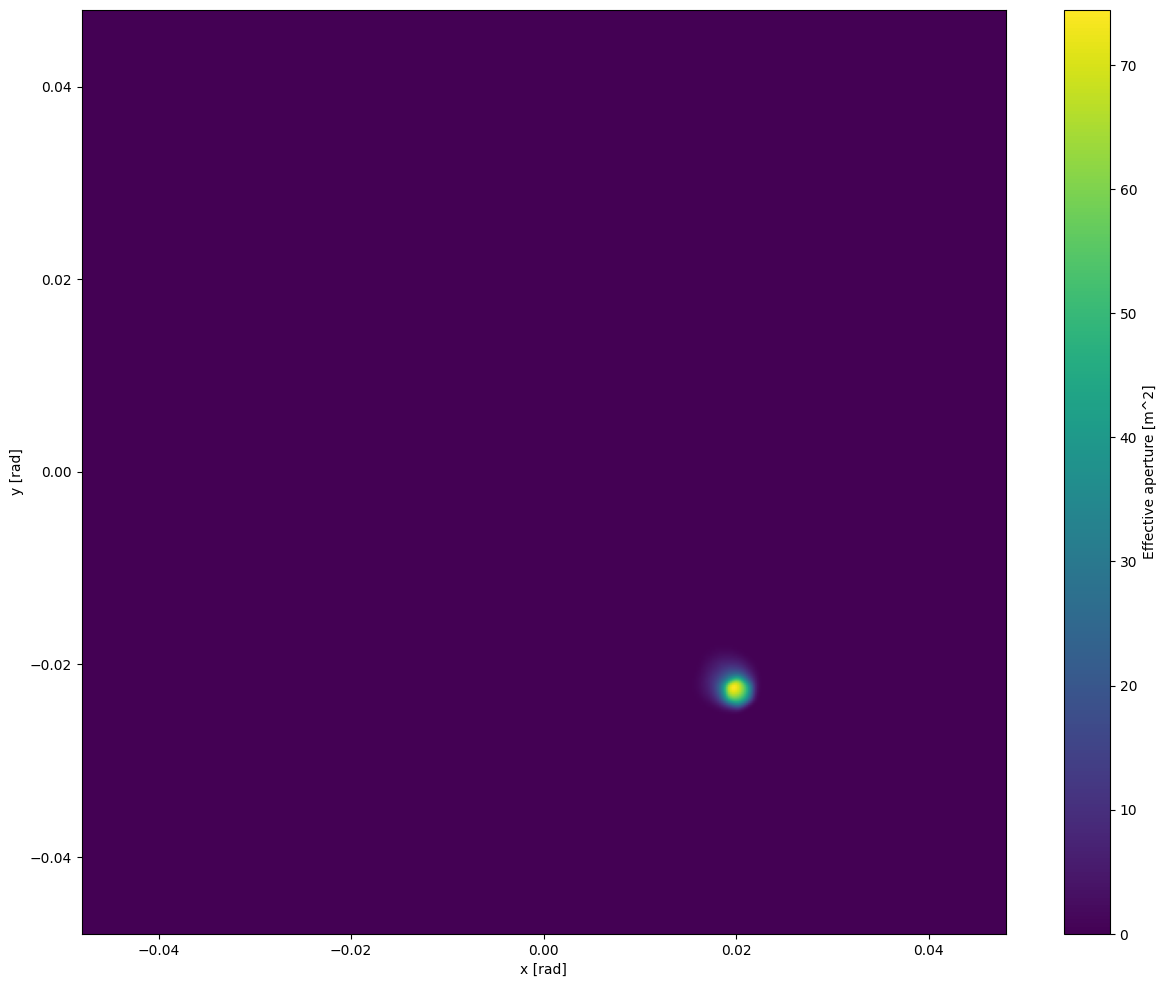

In [25]:
fig, ax = plt.subplots(figsize=(15, 12))

weights = r_m[:,300].reshape(n_side, n_side)

im = ax.imshow(
    weights,
    origin="lower",
    extent=[x1d[0], x1d[-1], y1d[0], y1d[-1]],
)

cbar = fig.colorbar(im, ax=ax)
cbar.set_label("Effective aperture [m^2]")  # colorbar label

ax.set_xlabel("x [rad]")
ax.set_ylabel("y [rad]")

plt.show()

# Transforming to per-pixel effective aperture array
For further use, separating the pixel responses into individual arrays of the same shape is advantageous. For this we choose 64x64 windows, to make these better for acceleration structures. We search the center of the box where values > 0 and then choose the 64x64 windows center on this row and column:

In [41]:
%%time
# Reshape once to 3D
weights_3d = r_m.reshape(n_side, n_side, 960).transpose(2, 0, 1)

tops = []
lefts = []
centers = []

for i in range(960):
    rows, cols = np.where(weights_3d[i] > 0)
    if len(rows) > 0:
        center_row = (rows.min() + rows.max()) // 2
        center_col = (cols.min() + cols.max()) // 2
        top = np.clip(center_row - 32, 0, n_side - 64)
        left = np.clip(center_col - 32, 0, n_side - 64)
        
    else:
        top, left = 0, 0
    tops.append(top)
    lefts.append(left)

CPU times: user 1.22 s, sys: 256 ms, total: 1.48 s
Wall time: 1.09 s


We can check how these individual pixel apertures look like:

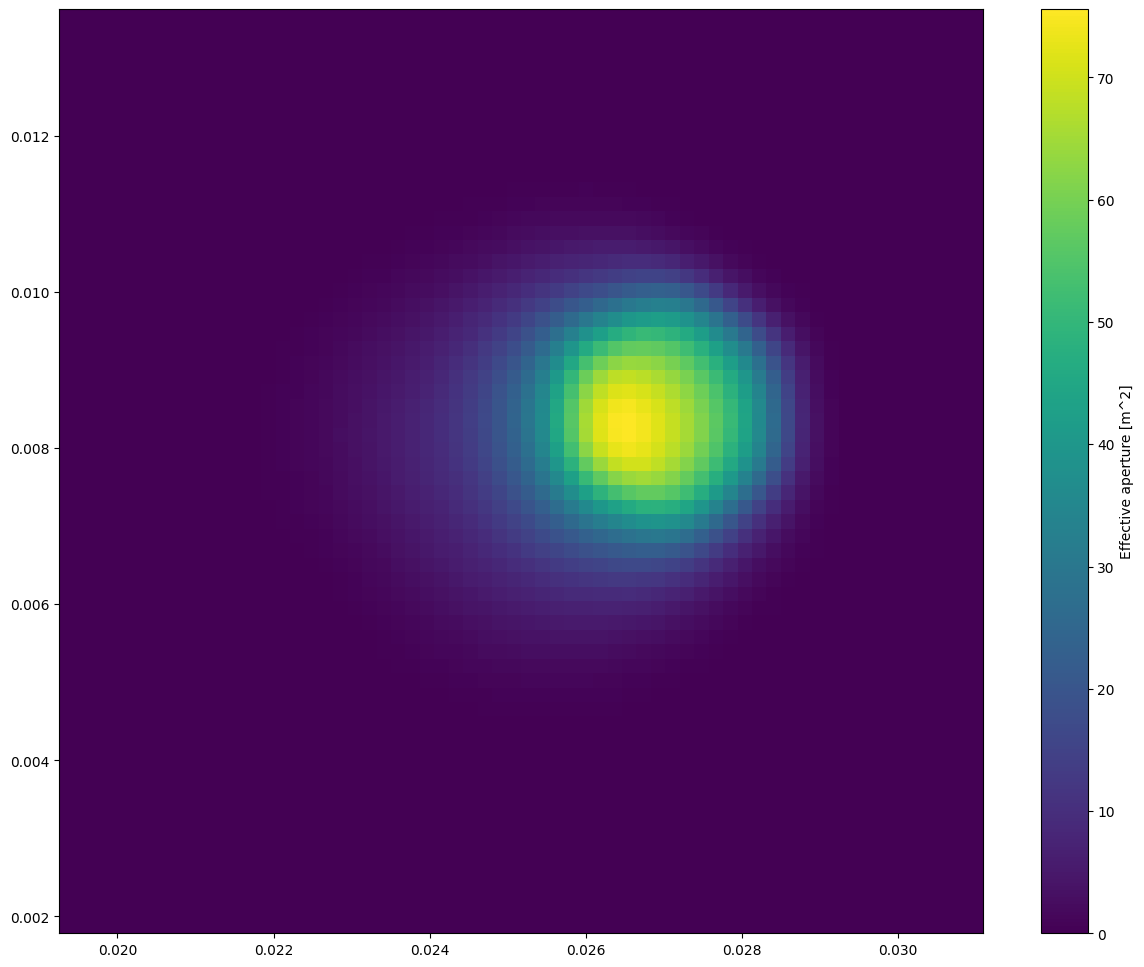

In [42]:
fig, ax = plt.subplots(figsize=(15, 12))

id = 122

top = tops[id]
left = lefts[id]

im = ax.imshow(
    weights_3d[id][top:top+64,left:left+64],
    origin="lower",
    extent=[x1d[left:left+64][0], x1d[left:left+64][-1], y1d[top:top+64][0], y1d[top:top+64][-1]]
)

cbar = fig.colorbar(im, ax=ax)
cbar.set_label("Effective aperture [m^2]")  # colorbar label

plt.show()